# Capstone Project - The Battle of the Neighborhoods
### COVID Risk Categories Applied For Reopening Restaraunts

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Sources](#data)
* [Dataset Structuring](#structuring)
* [Visualization](#visualization)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Among the numerous and diverse challenges humanity has faced through modern history, the recent Corona Virus pandemic showed itself as one of the most urgent and formidable one. Not only it brought unparalleled distress to every nation's healthcare system, but inflicted heavy losses in it's economies, specially regarding the survival of small businesses - mainly composed of family restaurants and stores. Still, despite minimal improvements in the infection curve scenarios, many countries are starting to reopen their economies due to the agrravating economical factors.

Invariably, the small food business are soon to receive quarantine eager clients, when the pandemic, despite still existing, has began to be treated as a "new normal" situation. In this scenario, this project aims to provide both businesses and clients a dynamic tool for evaluating the risk of attending/providing services at each neighbourhood, based on infection rate, populational density and quantity of stores avaliable (as wait lines and maximum capacity are a crucial factor imposed by health authorities and overall safety practices).

The initial goal of the project is to evaluate risks specifically for the **food service industry**. This model must not be used to analyse the risk of individual restaurants, but the risk associated with it's operation in it's neighbourhood. It's also expected to stabilish a relationship between clusters of venues and infection rate over neighborhoods. 


This is an easily replicable experiment for every city in the world, but, due to ease of access of data and the current high alert status, the case study will be applied to New York City.

## Data Sources <a name="data"></a>

The data needed for the project is listed below (besides the restaurants location data obtained from Foursquare API):


1.   Geographical data of buroughs and neighbourhoods of NYC and their latitude/longitude. Avaliable at: https://geo.nyu.edu/catalog/nyu_2451_34572. The data has been conviniently uploaded at the server as: https://cocl.us/new_york_dataset

Borough Neighborhood Latitude Longitude
35 Manhattan Turtle Bay 40.752042 -73.967708
36 Manhattan Tudor City 40.746917 -73.971219
37 Manhattan Stuyvesant Town 40.731000 -73.974052
38 Manhattan Flatiron 40.739673 -73.990947
39 Manhattan Hudson Yards 40.756658 -74.000111

2.   COVID-19 infection data, kill rate and quantity of registered cases. Avaliable at: https://www1.nyc.gov/site/doh/covid/covid-19-data.page (downloaded on 07/21/2020 as a csv for this project)

ZIP Neighborhood Borough Cases Cases per 100,000 Deaths per 100,000 Percent positive (of people tested)
10001 Chelsea/NoMad/West Chelsea Manhattan 415 1761,23 101,85 7,78
10002 Chinatown/Lower East Side Manhattan 1214 1581,65 208,45 11
10003 East Village/Gramercy/Greenwich Village Manhattan 504 936,77 63,2 5,92
10004 Financial District Manhattan 36 986,14 27,39 6,36
10005 Financial District Manhattan 76 905,18 23,82 5,71

3.   NYC population data per burough/neighbourhood. Avaliable at https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp. Data extracted via SODA API JSON: https://data.cityofnewyork.us/resource/swpk-hqdp.json 

## Dataset Structuring <a name="structuring"></a>

###Libraries

In [ ]:
import numpy as np #Vectorized data

import pandas as pd #Dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json #JSON Files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests #Requests

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim #Adress into lat/long

import matplotlib.cm as cm #Plotting and plotting modules
import matplotlib.colors as colors

import matplotlib.pyplot as plt #Plotting additional graphs
from matplotlib.ticker import PercentFormatter

from sklearn.cluster import KMeans #K-Means and Clustering

#!conda install -c conda-forge folium=0.5.0 --yes
import folium #Map Rendering (Folium)

print('Success!')

Success!


###Data Import

In [ ]:
# NYC Neighbouhood Names

!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset #Get JSON
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data) #Load data from JSON
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] #Specifying columns for DF
neighborhoods = pd.DataFrame(columns=column_names) #Create DF header

for data in neighborhoods_data: #Fill DF rows
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


neighborhoods.drop_duplicates(subset ="Neighborhood", keep = False, inplace = True) #Drop duplicates
print("Rows:",len(neighborhoods['Neighborhood'].unique())) #Checking size with data source

neighborhoods.sort_values("Neighborhood",inplace=True) #Sort alphabetically
neighborhoods.head()

Rows: 298


,Borough,Neighborhood,Latitude,Longitude
298,Bronx,Allerton,40.865788,-73.859319
215,Staten Island,Annadale,40.538114,-74.178549
241,Staten Island,Arden Heights,40.549286,-74.185887
227,Staten Island,Arlington,40.635325,-74.165104
228,Staten Island,Arrochar,40.596313,-74.067124


In [ ]:
#COVID Infection Data

covid_df=pd.read_csv('https://raw.githubusercontent.com/rafzss/Coursera_Capstone/master/Datasets/data-zsnEP.csv', index_col=None)
covid_df=covid_df.rename(columns={"Cases per 100,000":"Cases per 100k"})
covid_df=covid_df.rename(columns={"Deaths per 100,000":"Deaths per 100k"})
covid_df=covid_df.rename(columns={"Percent positive<br>(of people tested)":"Percent Positive"})
covid_df.drop(["ZIP"],axis=1,inplace=True)
print("Rows before splitting:",len(covid_df['Neighborhood'].unique())) #Checking size with data source

#Splitting rows of grouped neighborhoods

def splitDataFrameList(df,target_column,separator): # Based on: https://gist.github.com/jlln/338b4b0b55bd6984f883
    
    # df = dataframe to split,
    # target_column = the column containing the values to split
    # separator = the symbol used to perform the split
    # returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    #The values in the other columns are duplicated across the newly divided rows.
    
    row_accumulator = []
    def splitListToRows(row, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1, args = (separator, ))
    new_df = pd.DataFrame(row_accumulator)
    return new_df

covid_df=splitDataFrameList(covid_df,"Neighborhood","/")

covid_df=covid_df.sort_values('Cases per 100k').drop_duplicates('Neighborhood',keep='last') #Drop duplicates with lower 'Cases per 100k'
covid_df.sort_values("Neighborhood",inplace=True) #Sort alphabetically

print("Rows after splitting:",len(covid_df['Neighborhood'].unique())) #Checking size with data source
covid_df.head()

Rows before splitting: 162
Rows after splitting: 225


,Neighborhood,Borough,Cases,Cases per 100k,Deaths per 100k,Percent Positive
285,Airport,Queens,1690,4634.93,490.92,23.11
156,Allerton,Bronx,3164,4424.66,496.45,20.93
12,Alphabet City,Manhattan,774,1317.49,117.45,7.94
104,Annadale,Staten Island,1597,2648.23,97.84,16.97
88,Arrochar,Staten Island,1315,3089.68,187.97,18.20


In [ ]:
# NYC Population

nycpop=pd.read_csv('https://raw.githubusercontent.com/rafzss/Coursera_Capstone/master/Datasets/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv', index_col=None)
print("Latest Year:",nycpop["Year"].max()) #Get latest year of poll
nycpop=nycpop[nycpop['Year']==nycpop["Year"].max()] #Filter dataset by latest year

# This step approximates the population for neighborhoods that were grouped from the loaded dataset due to their geographical proximity (ex: Claremont-Bathgate)
# The total population is simply divided by the number of occurrances of neighborhoods in the grouped cell

nycpop=splitDataFrameList(nycpop,"NTA Name","-") #Split rows with more than one neighborhood
dupsdf=nycpop.pivot_table(index=['NTA Code'],aggfunc='size') #Count duplicates of each neighborhood code
nycpop=nycpop.merge(dupsdf.rename('Count').to_frame(),on=['NTA Code'],how='left') #Add previous count of duplicates to dataframe
nycpop['Population']=round(nycpop['Population']/nycpop['Count']) #Approximate population of originally grouped neighborhoods

nycpop.drop_duplicates(subset ="NTA Name", keep = False, inplace = True) #Drop duplicates
nycpop=nycpop.drop(['FIPS County Code','NTA Code','Count'],axis=1) #Drop unnecessary columns
print("Rows:",len(nycpop['NTA Name'].unique())) #Checking size with data source

nycpop.head()

Latest Year: 2010
Rows: 298


,Borough,Year,NTA Name,Population
0,Bronx,2010,Claremont,15539.0
1,Bronx,2010,Bathgate,15539.0
2,Bronx,2010,Eastchester,11506.0
3,Bronx,2010,Edenwald,11506.0
4,Bronx,2010,Baychester,11506.0


###Data Preparation

In [ ]:
neighborhoods.set_index('Neighborhood') #Set index as neighborhood
nycpop.set_index('NTA Name') #Set index as neighborhood
covid_df.set_index('Neighborhood') #Set index as neighborhood

df1 = pd.merge(nycpop, covid_df, how='inner', left_on='NTA Name', right_on='Neighborhood') #Merge COVID and Pop. data
df = pd.merge(neighborhoods,df1,how='inner',left_on='Neighborhood',right_on='NTA Name') #Merge df1 with neighborhood dataset --> Final dataset
df.drop_duplicates(subset ="Neighborhood_x", keep = False, inplace = True) #Drop duplicates
df=df.drop(['Borough_x','Year','NTA Name','Neighborhood_y','Borough_y'],axis=1) #Drop redundant columns
df=df.rename(columns={"Neighborhood_x":"Neighborhood"}) #Rename 'neighborhood'
df.set_index('Neighborhood') #Set index as neighborhood
print(df.shape)
df.head()

(150, 9)


,Borough,Neighborhood,Latitude,Longitude,Population,Cases,Cases per 100k,Deaths per 100k,Percent Positive
0,Bronx,Allerton,40.865788,-73.859319,14452.0,3164,4424.66,496.45,20.93
1,Staten Island,Annadale,40.538114,-74.178549,6942.0,1597,2648.23,97.84,16.97
2,Staten Island,Arrochar,40.596313,-74.067124,5360.0,1315,3089.68,187.97,18.20
3,Queens,Arverne,40.589144,-73.791992,12295.0,666,3310.10,462.22,17.26
4,Queens,Auburndale,40.761730,-73.791762,19996.0,900,2043.10,152.10,13.93


##### We see that the dataset went from the original 298 rows of the neighborhood dataset to 150, due to removal of duplicates and wrong matchings of the neighborhood strings of each dataset. Python allows for ease to use matching alghoritms through pre-built libraries, such as Levenshtein's alghoritm in the 'fuzzywuzzy' library. This will not be applied in this project so as to not overextend it.

## Data Visualization <a name="visualization"></a>

In [ ]:
#Locate NYC Coordinates

address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# Create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Analysis <a name="analysis"></a>

###Foursquare Connection

In [ ]:
CLIENT_ID = 'VLXFKV40KQLKJP3NM3U2VTOWIZYHKJXM3CXWH3SUVILRPA5D' # your Foursquare ID
CLIENT_SECRET = 'QJVKBVYQLA52BKUEV3AQGQPUBB0UFP0ORLPQTMYXBAPGZMZD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VLXFKV40KQLKJP3NM3U2VTOWIZYHKJXM3CXWH3SUVILRPA5D
CLIENT_SECRET:QJVKBVYQLA52BKUEV3AQGQPUBB0UFP0ORLPQTMYXBAPGZMZD


###Foursquare Venues and Categories

In [ ]:
#Standard Function for fetching Foursquare data

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
# Fetching Foursquare Data:

LIMIT=100 #Limit of venues returned by Foursquare API (for each neighborhood)
radius=500 #Limit of radius for getting venues

nyc_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

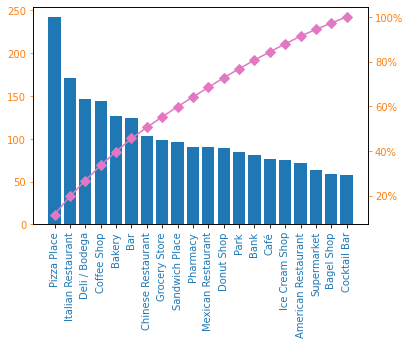

In [ ]:
# Pareto Chart

df_pareto = nyc_venues.groupby(['Venue Category'])['Venue Category'].count().to_frame(name='Venues').reset_index()
df_pareto.index=df_pareto['Venue Category']
df_pareto = df_pareto.sort_values(by='Venues',ascending=False)
df_pareto = df_pareto.nlargest(20,['Venues'])
df_pareto["cumulative_percent"] = df_pareto["Venues"].cumsum()/df_pareto["Venues"].sum()*100 # Cumulative Percentage Line
df_pareto

fig, ax = plt.subplots()
ax.bar(df_pareto.index, df_pareto["Venues"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto["cumulative_percent"], color="C6", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C1")
ax2.tick_params(axis="y", colors="C1")

for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        tick.set_color("C0")
plt.show()

####As imagined, food services places correspond to the vast majority of the venues analysed (at least from the top 20 venues).

In [ ]:
# Grouping venues into neighborhoods

nyc_grouped=nyc_venues.groupby(['Neighborhood'])['Venue Category'].count().to_frame(name='Venues Qty').reset_index() 
nyc_grouped.sort_values
print(nyc_grouped.shape)


# Merging venue data with dataset:

df2 = pd.merge(df,nyc_grouped,how='left',left_on='Neighborhood',right_on='Neighborhood')
print(df2.shape)

df2.head() #This is the final dataset for analysis
# Some columns will not be used, but they provide details for future analysis and comparisons

(150, 2)
(150, 10)
There are 357 uniques categories.


,Borough,Neighborhood,Latitude,Longitude,Population,Cases,Cases per 100k,Deaths per 100k,Percent Positive,Venues Qty
0,Bronx,Allerton,40.865788,-73.859319,14452.0,3164,4424.66,496.45,20.93,26
1,Staten Island,Annadale,40.538114,-74.178549,6942.0,1597,2648.23,97.84,16.97,11
2,Staten Island,Arrochar,40.596313,-74.067124,5360.0,1315,3089.68,187.97,18.20,19
3,Queens,Arverne,40.589144,-73.791992,12295.0,666,3310.10,462.22,17.26,20
4,Queens,Auburndale,40.761730,-73.791762,19996.0,900,2043.10,152.10,13.93,20


###Cluster Neighborhoods

In [ ]:
# K-Means for clustering neighborhoods into 4 risk rates (Low, Average, High and Critical)

df_kcluster = df2.filter(['Cases per 100k','Venues Qty']) # Dataframe with X

k=4
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_kcluster) # Run k-means clustering
kmeans.labels_[0:10] # Check cluster labels generated for each row in the dataframe


# Create new dataframe with clusters

# add clustering labels
df_kcluster.insert(0, 'Cluster Labels', kmeans.labels_)
df_kcluster=df_kcluster.drop(['Cases per 100k','Venues Qty'],axis=1) # Drop redundant columns
df_final = df2.merge(df_kcluster,left_index=True,right_index=True) # Merge Cluster Labels with dataset

print(df_final.shape)
df_final.head()

(150, 11)


,Borough,Neighborhood,Latitude,Longitude,Population,Cases,Cases per 100k,Deaths per 100k,Percent Positive,Venues Qty,Cluster Labels
0,Bronx,Allerton,40.865788,-73.859319,14452.0,3164,4424.66,496.45,20.93,26,2
1,Staten Island,Annadale,40.538114,-74.178549,6942.0,1597,2648.23,97.84,16.97,11,3
2,Staten Island,Arrochar,40.596313,-74.067124,5360.0,1315,3089.68,187.97,18.20,19,0
3,Queens,Arverne,40.589144,-73.791992,12295.0,666,3310.10,462.22,17.26,20,0
4,Queens,Auburndale,40.761730,-73.791762,19996.0,900,2043.10,152.10,13.93,20,3


###Visualize Clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion<a name="results"></a>

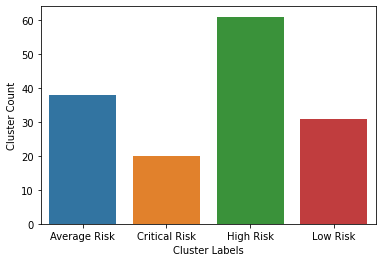

In [ ]:
import seaborn as sns # Plotting library

# Bar Plot

df_plot = df_final.filter(['Cases per 100k','Venues Qty','Cluster Labels'],axis=1)
df_plot['Cluster Labels']=df_plot['Cluster Labels'].replace(0,'High Risk').replace(1,'Low Risk').replace(2,'Critical Risk').replace(3,'Average Risk') # Replace cluster labels for arbitrary labels
df_count = df_plot.groupby(['Cluster Labels'])['Cluster Labels'].count().to_frame(name='Cluster Count').reset_index() # Perform a count groupby
df_count.head()

sns.barplot(x='Cluster Labels',y='Cluster Count',data=df_count) # Bar Plot

In the atual scenario (07-23-2020), New York City shows a higher amount of neighborhoods with 'High Risk' cases.

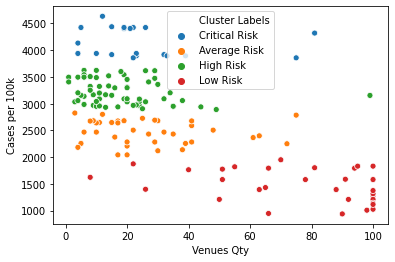

In [ ]:
# Scatterplot of Cluster Labels

sns.scatterplot(x='Venues Qty',y='Cases per 100k',data=df_plot,hue='Cluster Labels')

We can see then the classification by clusters that represent the healthcare precautions strictness for each risk group (cluster labels). It's intuitive to think that neighborhoods with a high avaliability of stores and low infection rate may present lower risks than the opposite scenario. It is noted as well that the clusters have their frontiers in a clear geospacial manner, but this probably represents the correlation between amount of venues, people transit and socioeconomic bias of each region, meaning that the relationship of geography is not of causation.


*   Group 0: High Risk
*   Group 1: Low Risk
*   Group 2: Critical Risk
*   Group 3: Average Risk





In summary, the results did not display abnormalities or an excessive amount of outliers. The data showed a rather clear clustering, indexed by the independent variables of the study. It's important to remember that K-means is an unsupervised alghoritm and should not be artificially labed. The previous results show a interpretation of the randomic data generated in this session.

## Conclusion <a name="conclusion"></a>

Despite discarding an elevated amount of data due to string mismatching of geospacial data definitions and numeric data of pandemic, the model showed itself to clearly define well structured cluster labels, without evident outliers.

The ease of use of Foursquare API and Python's libraries allowed for an agile and assertive approach to such urgent and delicate problem. The complexity of the pandemic scenario which we live on is not denied, but the model could - simply - stabilish action response levels for the variety of healthcare solutions according to the social context of each neighborhood, where it could serve as a response guide, particularly to small towns that do not rely on a structured core of medical scientists.

Future refinement of this project involve better string comparison tools for merging different sourced datasets and inclusion of other variables to the predicted model.